<h1>Handwritten Digit Recognition on MNIST with a Two-Layer Neural Network</h1>


---



Original model by Samsom Zhang. In this work, I normalize the init_params and replace standard gradient descent with Nesterov Momentum.

These modifications improve the model’s performance by accelerating the optimization process, resulting in a test accuracy exceeding 90%.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mnist/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2>Data Preprocessing and Train/Test Split</h2>
<p>Shuffle the dataset, split it into training and test sets, and normalize the pixel values to the [0, 1] range for better training performance.</p>


In [4]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_test = data[0:1000].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

Our neural network (NN) features a straightforward two-layer architecture.
The input layer, denoted as a[0], consists of 784 units, each corresponding to one of the 784 pixels in a 28x28 input image. The hidden layer, a[1], contains 10 units with ReLU activation, while the output layer, a[2], also has 10 units, representing the 10 digit classes, and employs softmax activation to provide class probabilities.

<h2>Neural Network Forward and Backward Propagation</h2>
<p>This section covers the initialization of parameters, forward propagation through the network, and backward propagation for gradient computation and weight updates.</p>


In [5]:
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [7]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [8]:
def nesterov_gradient_descent(X, Y, alpha, iterations, mu=0.9):
    W1, b1, W2, b2 = init_params()

    # Inicializamos las velocidades a cero
    vW1 = np.zeros_like(W1)
    vb1 = np.zeros_like(b1)
    vW2 = np.zeros_like(W2)
    vb2 = np.zeros_like(b2)

    for i in range(iterations):
        # Lookahead
        W1_look = W1 + mu * vW1
        b1_look = b1 + mu * vb1
        W2_look = W2 + mu * vW2
        b2_look = b2 + mu * vb2

        Z1, A1, Z2, A2 = forward_prop(W1_look, b1_look, W2_look, b2_look, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1_look, W2_look, X, Y)

        # Actualizamos velocidades (momentum)
        vW1 = mu * vW1 - alpha * dW1
        vb1 = mu * vb1 - alpha * db1
        vW2 = mu * vW2 - alpha * dW2
        vb2 = mu * vb2 - alpha * db2

        # Aplicamos los pasos reales
        W1 += vW1
        b1 += vb1
        W2 += vW2
        b2 += vb2

        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))

    return W1, b1, W2, b2

Applying Nesterov Gradient Descent for Parameter Optimization

In [9]:
W1, b1, W2, b2 = nesterov_gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[2 0 0 ... 2 0 0] [8 2 0 ... 4 6 4]
0.10019512195121952
Iteration:  10
[3 2 0 ... 3 6 0] [8 2 0 ... 4 6 4]
0.3864146341463415
Iteration:  20
[8 2 0 ... 8 6 4] [8 2 0 ... 4 6 4]
0.7592682926829268
Iteration:  30
[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]
0.8242195121951219
Iteration:  40
[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]
0.8601219512195122
Iteration:  50
[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]
0.8774634146341463
Iteration:  60
[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]
0.8863658536585366
Iteration:  70
[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]
0.892390243902439
Iteration:  80
[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]
0.8972682926829268
Iteration:  90
[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]
0.9007560975609756
Iteration:  100
[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]
0.9034878048780488
Iteration:  110
[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]
0.9060487804878049
Iteration:  120
[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]
0.9091219512195122
Iteration:  130
[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]
0.9109268292682927
Iteration:  140
[

The make_predictions function generates predictions using the trained model. The test_prediction function visualizes the predicted and actual labels for a given image from the training set.

In [10]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

<h2>Testing Predictions on Multiple Training Samples</h2>


Prediction:  [8]
Label:  8


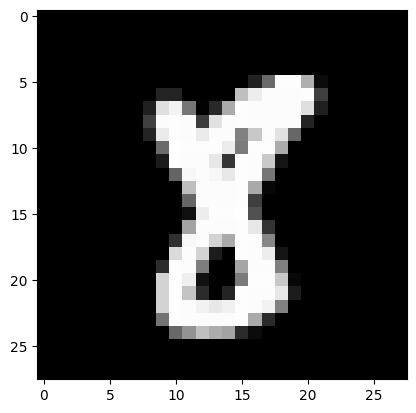

Prediction:  [2]
Label:  2


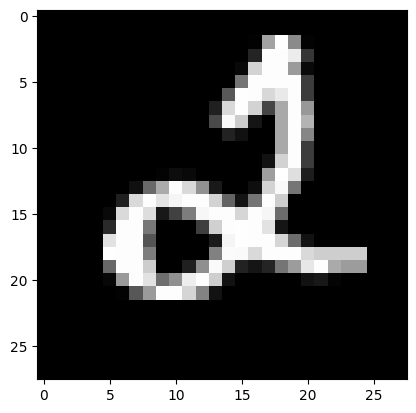

Prediction:  [0]
Label:  0


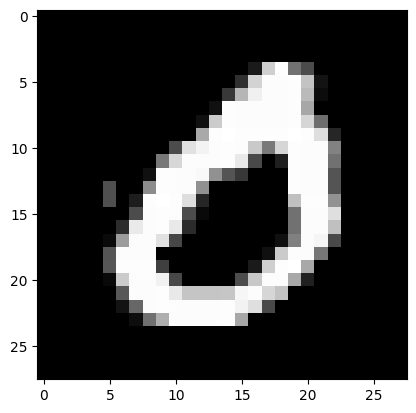

Prediction:  [1]
Label:  4


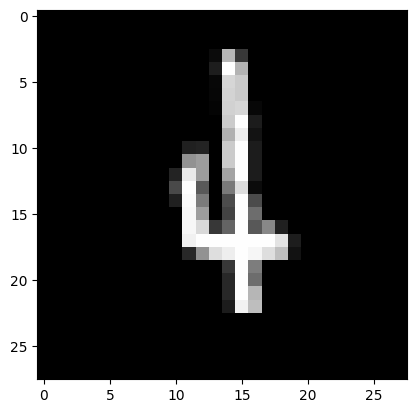

Prediction:  [5]
Label:  5


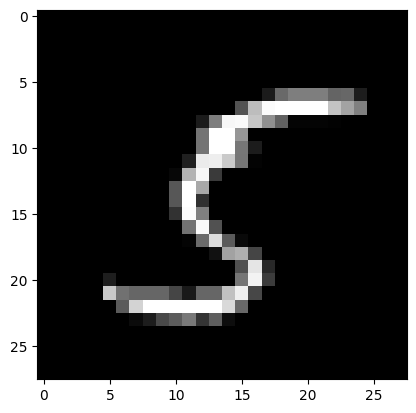

Prediction:  [2]
Label:  2


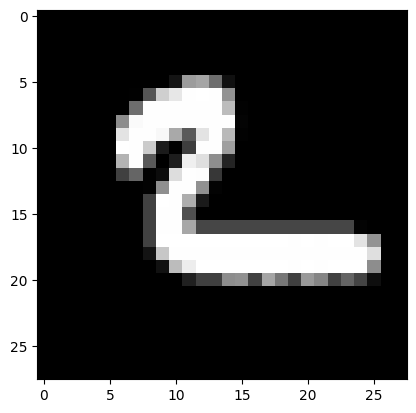

Prediction:  [6]
Label:  6


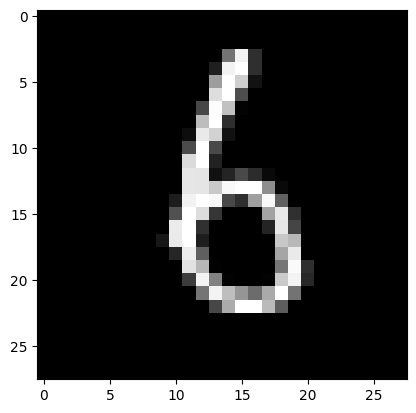

Prediction:  [6]
Label:  6


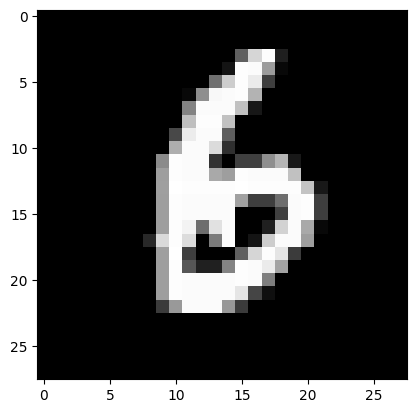

Prediction:  [2]
Label:  2


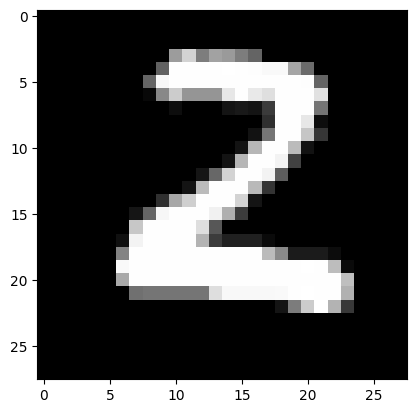

Prediction:  [7]
Label:  7


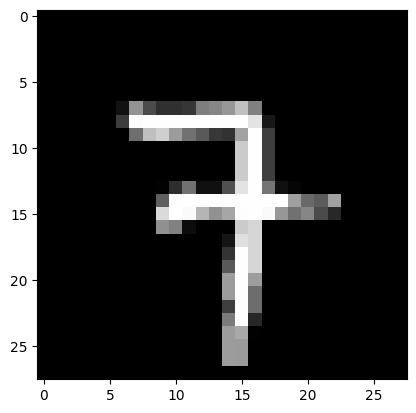

In [12]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)
test_prediction(4, W1, b1, W2, b2)
test_prediction(5, W1, b1, W2, b2)
test_prediction(6, W1, b1, W2, b2)
test_prediction(7, W1, b1, W2, b2)
test_prediction(8, W1, b1, W2, b2)
test_prediction(9, W1, b1, W2, b2)

Finally, we evaluate the model's performance by calculating its accuracy on the test set, providing a measure of how well the model generalizes to unseen data.

In [14]:
test_predictions = make_predictions(X_train, W1, b1, W2, b2)
get_accuracy(test_predictions, Y_train)

[8 2 0 ... 4 6 4] [8 2 0 ... 4 6 4]


np.float64(0.9371707317073171)

Over 90% accuracy with a simple model – quite impressive!